# QOSF Mentorship Programme
## Task 2

Implement a circuit that returns $| 01 \rangle$ and $|10 \rangle$ with equal probability.

Requirements :
- The circuit should consist only of CNOTs, RXs and RYs. 
- Start from all parameters in parametric gates being equal to 0 or randomly chosen. 
- You should find the right set of parameters using gradient descent (you can use more advanced optimization methods if you like). 
- Simulations must be done with sampling - i.e. a limited number of measurements per iteration and noise. 

Compare the results for different numbers of measurements: 1, 10, 100, 1000. 

Bonus question:
How to make sure you produce state $|01 \rangle + |10 \rangle$ and not $|01 \rangle + e^{i\phi} |10 \rangle$ (including $|01\rangle - |10\rangle$)?

I have decided to use Qiskit in my code as I'm quite comfortable with it. I have also implemented a model using PennyLane which provides builtin functions for machine learning and optimization.

# Implementation in Qiskit

In [1]:
# Importing necessary libraries 
# and predefining backends
from qiskit import execute, Aer, QuantumCircuit, IBMQ
from qiskit.visualization import plot_histogram, plot_state_qsphere
import numpy as np
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output
%matplotlib inline

from qiskit.providers.aer.noise import NoiseModel
provider = IBMQ.load_account()
backend = provider.get_backend('ibmq_valencia')
noise_model = NoiseModel.from_backend(backend)

# Get coupling map from backend
coupling_map = backend.configuration().coupling_map

# Get basis gates from backend
basis_gates = noise_model.basis_gates

qasm_backend = Aer.get_backend('qasm_simulator')
statevector_backend = Aer.get_backend('statevector_simulator')

/home/ashish/.local/lib/python3.8/site-packages/qiskit/providers/ibmq/ibmqfactory.py:192: UserWarning: Timestamps in IBMQ backend properties, jobs, and job results are all now in local time instead of UTC.
  warnings.warn('Timestamps in IBMQ backend properties, jobs, and job results '


## Reference circuit
Let us implement a quantum circuit with known parameters that yields an equal probability of $| 01 \rangle$ and $| 10 \rangle$ to get an idea of what gates the circuit must consist of.

In [2]:
# Define a quantum circuit consisting of 2 qubits with parametric gates RX, RY and CNOT
qc0 = QuantumCircuit(2)

# Define a reference circuit
qcr = QuantumCircuit(2)

# Hadamard gate on qubit 0
qc0.ry(np.pi/2, 0)
qc0.rx(np.pi, 0)
qcr.h(0)

# X gate on qubit 1
qc0.rx(np.pi, 1)
qcr.x(1)

# CNOT gate with qubit 0, qubit 1 as the control and target qubits respectively
qc0.cx(0,1)
qcr.cx(0,1)
qcr.measure_all()

Reference circuit: 


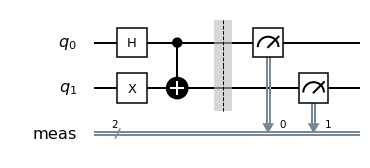

In [3]:
print("Reference circuit: ")
qcr.draw()

Reference circuit with Rx, Ry and CNOT gates: 


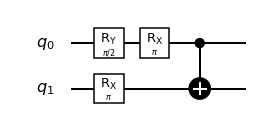

In [4]:
print("Reference circuit with Rx, Ry and CNOT gates: ")
qc0.draw()

### Final state of the reference circuit before measurement
Let us plot the final state of the reference circuit just before measurement on the qsphere.

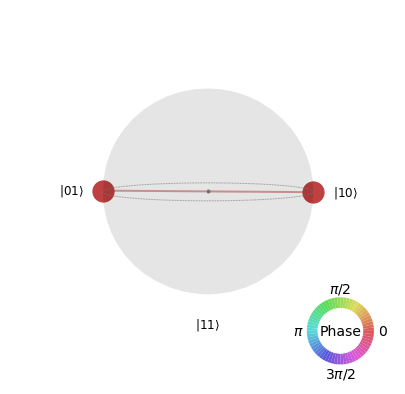

In [5]:
final_state = execute(qc0, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

### Measurement results on a histogram
Let us now measure the final state and plot it on a histogram

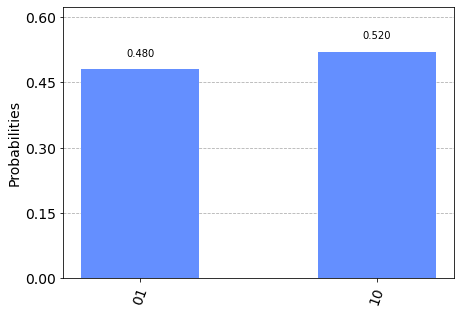

In [6]:
qc0.measure_all()
counts = execute(qc0, qasm_backend, shots=1000).result().get_counts()
plot_histogram(counts)

# Approach to the problem

As can be seen from the histogram plot, we get the desired output. Our goal now is to parameterize the circuit by introducing unknown parameters to the RX and RY gates.

When trying to find the optimal solution to the parameterized problem, the CNOT gate does not play a role since it does not depend on parameters. Hence, the goal is to find the optimum solution to the state of the qubits just before applying the CNOT gate.

Let us see the effect of the gates used in the reference circuit to find the state of the system at the end of the circuit.

All qubits are initialized to the state $| 0 \rangle$ thus initializing the system at $| 00 \rangle$. Applying a Hadamard gate to the 1st qubit yields, 

$$ |00 \rangle \longrightarrow |0 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

It is a good point to note here that Qiskit orders its qubits in a different way compared to the convention followed in most textbooks. In Qiskit, if $q_0$ and $q_1$ are the 1st and 2nd qubits respectively, then the composite system is written as

$$ |q_1 q_0 \rangle = |q_1 \rangle \otimes |q_0 \rangle$$

Now applying an X gate onto the second qubit,

$$ |0 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle) \longrightarrow |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle)$$

Finally applying a CNOT gate (with the first qubit as the control and the second qubit as the target), we get

$$ |1 \rangle \otimes \frac{1}{\sqrt{2}} (|0 \rangle + |1 \rangle) \longrightarrow \frac{1}{\sqrt{2}} (|10 \rangle + |01 \rangle) = |\psi \rangle$$

This final state $|\psi \rangle$ upon measurement, will yield $|10 \rangle$ with a probability of 0.5 and $|01 \rangle$ with a probability of 0.5.

However, since we are not concerned with unparameterized operations, we only have to worry about the state of the system just before the application of the CNOT gate. That state would be,

$$ | \phi \rangle = |1 \rangle \otimes \frac{1}{\sqrt{2}}(|0 \rangle + |1 \rangle)$$

This state is clearly unentangled, meaning that the corresponding qubits are independent and that we can treat the problem as 2 separate optimization problems.

In [7]:
## Initializing parameters with random values

# q0_thetas holds parameters for the first qubit and q1_thetas holds parameters for the second qubit
q0_thetas = [ random.uniform(0.001, 2 * np.pi) for i in range(2)]
q1_thetas = [ random.uniform(0.001, 2 * np.pi) for i in range(2)]

Let us define a function that returns a parameterized quantum circuit.

In [8]:
def circuit(params0, params1):
    circuit = QuantumCircuit(2)
    circuit.ry(params0[0], 0)
    circuit.rx(params0[1], 0)
    circuit.ry(params1[0], 1)
    circuit.rx(params1[1], 1)
    
    return circuit

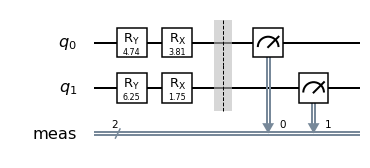

In [9]:
circ = circuit(q0_thetas, q1_thetas)
circ.measure_all()
circ.draw()

Let us plot the probabilities of measuring all possible states of this system on a histogram.

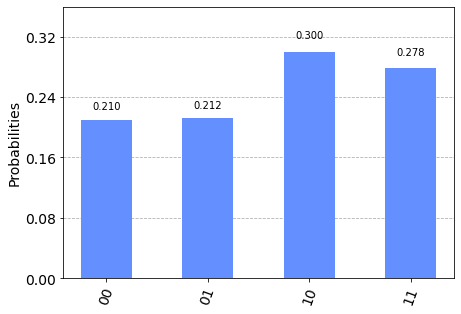

In [10]:
cnt = execute(circ, qasm_backend).result().get_counts()
plot_histogram(cnt)

Our goal here is to optimize the parameters such that measuring $q_1$ yields that state $|1 \rangle$ with probability 1 and measuring $q_0$ yields the states $|0 \rangle$ and $|1 \rangle$ with probabilities 0.5 each.

## Cost function

Since the 2 qubits can be treated independently, let us define 2 cost functions to optimize their respective parameters.

Let $J_0$ and $J_1$ be the cost functions of $q_0$ and $q_1$ respectively. Since we're dealing with probability, let us implement it into these cost functions. 

### Qubit 0:
$$ J_0 = \frac{1}{4} ((P_0 - 0.5)^2 + (P_1 - 0.5)^2)$$

### Qubit 1:
$$ J_1 = \frac{1}{4} (P_0^2 + (P_1 - 1)^2)$$

where $P_0$ and $P_1$ are the probabilities of measuring $|0 \rangle$ and $|1 \rangle$ respectively.

We wish to minimize the above 2 cost functions using batch gradient descent as our optimization method.

Now let us analytically deduce the operations the gates perform on our initial composite qubit state $| 00 \rangle$.

The $R_X$ gate corresponds to,

$$
R_X (\theta) = 
\begin{pmatrix}
\cos \frac{\theta}{2} & -i \sin \frac{\theta}{2} \\
-i \sin \frac{\theta}{2} & \cos \frac{\theta}{2} \\
\end{pmatrix}
$$

The $R_Y$ gate corresponds to,

$$
R_Y (\theta) = 
\begin{pmatrix}
\cos \frac{\theta}{2} & - \sin \frac{\theta}{2} \\ 
\sin \frac{\theta}{2} & \cos \frac{\theta}{2} \\  
\end{pmatrix}
$$


The operation of these matrices on initial state $|0 \rangle$ yields,

$$
|0 \rangle \xrightarrow[]{R_Y (\theta_0)}
\begin{pmatrix}
\cos \frac{\theta_0}{2} \\ 
\sin \frac{\theta_0}{2} \\  
\end{pmatrix}
\xrightarrow[]{R_X (\theta_1)}
\begin{pmatrix}
\cos \frac{\theta_0}{2} \cos \frac{\theta_1}{2} - i \sin \frac{\theta_0}{2} \sin \frac{\theta_1} {2} \\
-i \sin \frac{\theta_1}{2} \cos \frac{\theta_0}{2} + \cos \frac{\theta_1}{2} \sin \frac{\theta_0}{2} \\
\end{pmatrix}
= | \psi \rangle
$$

This is the state obtained on both the qubits in the unparameterized circuit. From this state $| \psi \rangle$, the probabilities of obtaining $|0 \rangle$ and $|1 \rangle$ can be obtained by computing the corresponding square of modulus of inner products,

$$
P_0 = | \langle 0 | \psi \rangle |^2 = \cos^2 \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} + \sin^2 \frac{\theta_0}{2} \sin^2 \frac{\theta_1}{2}
$$

$$
P_1 = | \langle 1 | \psi \rangle |^2 = \cos^2 \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} + \sin^2 \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2}
$$

## Batch Gradient Descent

Let us now get into the meat of the optimization problem. Since we are implementing batch gradient descent, the parameters have to be updated as

$$
\theta_{i+1} := \theta_i - \alpha \frac{\partial }{\partial \theta_i} J (\theta_0, \theta_1)
$$

where $\theta_{i+1}$ is the newly updated parameter after the i$^{th}$ iteration and $\alpha$ is the learning rate.



### Evaluating terms of the expression for gradient descent

Computing the respective partial derivatives of both cost funtions $J_0$ and $J_1$,

$$
\frac{\partial J_0}{\partial \theta_0} = \frac{1}{2}\left((P_0 - 0.5) \frac{\partial P_0}{\partial \theta_0} + (P_1 - 0.5) \frac{\partial P_1}{\partial \theta_0}\right)
$$

$$
\frac{\partial J_0}{\partial \theta_1} = \frac{1}{2}\left((P_0 - 0.5) \frac{\partial P_0}{\partial \theta_1} + (P_1 - 0.5) \frac{\partial P_1}{\partial \theta_1}\right)
$$

$$
\frac{\partial J_1}{\partial \theta_0} = \frac{1}{2}\left(P_0 \frac{\partial P_0}{\partial \theta_0} + (P_1 - 1) \frac{\partial P_1}{\partial \theta_0}\right)
$$

$$
\frac{\partial J_1}{\partial \theta_1} = \frac{1}{2}\left(P_0 \frac{\partial P_0}{\partial \theta_1} + (P_1 - 1) \frac{\partial P_1}{\partial \theta_1}\right)
$$

Now, computing the partial derivatives of $P_0$ and $P_1$ with respect to the parameters,

$$
\frac{\partial P_0}{\partial \theta_0} = - \cos \frac{\theta_0}{2} \sin \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} + \sin \frac{\theta_0}{2} \cos \frac{\theta_0}{2} \sin^2 \frac{\theta_1}{2} = -\frac{1}{2} \sin \theta_0 \cos \theta_1
$$

$$
\frac{\partial P_0}{\partial \theta_1} = - \cos \frac{\theta_1}{2} \sin \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2} + \sin \frac{\theta_1}{2} \cos \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} = -\frac{1}{2} \sin \theta_1 \cos \theta_0
$$

$$
\frac{\partial P_1}{\partial \theta_0} = \sin \frac{\theta_0}{2} \cos \frac{\theta_0}{2} \cos^2 \frac{\theta_1}{2} - \sin^2 \frac{\theta_1}{2} \cos \frac{\theta_0}{2} \sin \frac{\theta_0}{2} = \frac{1}{2} \sin \theta_0 \cos \theta_1
$$

$$
\frac{\partial P_1}{\partial \theta_1} = -\cos \frac{\theta_1}{2} \sin \frac{\theta_1}{2} \sin^2 \frac{\theta_0}{2} + \sin \frac{\theta_1}{2} \cos \frac{\theta_1}{2} \cos^2 \frac{\theta_0}{2} = \frac{1}{2} \sin \theta_1 \cos \theta_0
$$

## Partial derivatives of $J_i$ in terms of parameters $\theta_0$, $\theta_1$
Substituting the above relations into the equations for the partial derivatives of $J_i$, we get

$$
\frac{\partial J_0}{\partial \theta_0} = \frac{1}{4} \sin \theta_0 \cos \theta_1 (P_1 - P_0)
$$

$$
\frac{\partial J_0}{\partial \theta_1} = \frac{1}{4} \sin \theta_1 \cos \theta_0 (P_1 - P_0)
$$

$$
\frac{\partial J_1}{\partial \theta_0} = \frac{1}{4} \sin \theta_0 \cos \theta_1 (P_1 - P_0 -1)
$$

$$
\frac{\partial J_1}{\partial \theta_1} = \frac{1}{4} \sin \theta_1 \cos \theta_0 (P_1 - P_0 -1)
$$

Let us implement the above formulation in python.

In [11]:
## params = [theta0, theta1]

# Probability of measuring state |0>
def prob0(params):
    p0 = (np.cos(params[0]/2)**2)*(np.cos(params[1]/2)**2) + (np.sin(params[0]/2)**2)*(np.sin(params[1]/2)**2)
    return p0

# Probability of measuring state |1>
def prob1(params):
    p1 = (np.sin(params[0]/2)**2)*(np.cos(params[1]/2)**2) + (np.cos(params[0]/2)**2)*(np.sin(params[1]/2)**2)
    return p1

In [12]:
# Function that returns the cost function for given qubit (0 or 1)
def cost(params, qubit):
    if qubit==0:
        j0 = 0.25 * ((prob0(params) - 0.5)**2 + (prob1(params) - 0.5)**2)
        return j0
    
    elif qubit==1:
        j1 = 0.25 * (prob0(params)**2 + (prob1(params) - 1)**2)
        return j1
    
    else:
        print("Qubit index out of range!!!")
        exit()

In [13]:
## Computes gradient for qubit 0
# q0_thetas = [theta0, theta1]; i = index (0 for theta0, 1 for theta1) denotes the theta w.r.t the partial derivative
def gradient_q0(q0_thetas, i):
    p0 = prob0(q0_thetas)
    p1 = prob1(q0_thetas)
    
    if i==0:
        grad = 0.25 * np.sin(q0_thetas[0]) * np.cos(q0_thetas[1]) * (p1 - p0)
        return grad
    
    elif i==1:
        grad = 0.25 * np.sin(q0_thetas[1]) * np.cos(q0_thetas[0]) * (p1 - p0)
        return grad
    
    else:
        print("Incorrect index!!!")
        exit()
    
## Computes gradient for qubit 1
# q1_thetas = [theta0, theta1]; i = index (0 for theta0, 1 for theta1) denotes the theta w.r.t the partial derivative
def gradient_q1(q1_thetas, i):
    p0 = prob0(q1_thetas)
    p1 = prob1(q1_thetas)
    
    if i==0:
        grad = 0.25 * np.sin(q1_thetas[0]) * np.cos(q1_thetas[1]) * (p1 - p0 - 1)
        return grad
    
    elif i==1:
        grad = 0.25 * np.sin(q1_thetas[1]) * np.cos(q1_thetas[0]) * (p1 - p0 - 1)
        return grad
    
    else:
        print("Incorrect index!!!")
        exit()

In [14]:
## Gradient descent optimizer function
# params = [theta0, theta1], qubit is the index of the qubit parameters being optimized
def optimizer(params, learning_rate, qubit):
    if qubit==0:
        temp0 = params[0] - (learning_rate * gradient_q0(params, 0))
        temp1 = params[1] - (learning_rate * gradient_q0(params, 1))
        params[0] = temp0
        params[1] = temp1
       
    elif qubit==1:
        temp0 = params[0] - (learning_rate * gradient_q1(params, 0))
        temp1 = params[1] - (learning_rate * gradient_q1(params, 1))
        params[0] = temp0
        params[1] = temp1
        
    else:
        print("Out of range of qubits!!!")
        exit()

In [15]:
## Initializing important variables
# Number of iterations
iterations = 100

# Learning rate
learning_rate = 0.4

In [16]:
# Make copies of the initial parameter so as to compare the values of the parameters before and after optimization
params0 = q0_thetas.copy()
params1 = q1_thetas.copy()

In [17]:
# Qubit 0 optimization
print("Optimizing qubit 0:")
for i in range(iterations):
    optimizer(params0, learning_rate, 0)
    
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i+1, cost(params0, 0)))
        
print("\nOptimizing qubit 1:")
    
# Qubit 1 optimization
for j in range(iterations):
    optimizer(params1, learning_rate, 1)
    
    if (j + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(j+1, cost(params1, 1)))

Optimizing qubit 0:
Cost after step     5:  0.0000285
Cost after step    10:  0.0000151
Cost after step    15:  0.0000080
Cost after step    20:  0.0000042
Cost after step    25:  0.0000022
Cost after step    30:  0.0000012
Cost after step    35:  0.0000006
Cost after step    40:  0.0000003
Cost after step    45:  0.0000002
Cost after step    50:  0.0000001
Cost after step    55:  0.0000000
Cost after step    60:  0.0000000
Cost after step    65:  0.0000000
Cost after step    70:  0.0000000
Cost after step    75:  0.0000000
Cost after step    80:  0.0000000
Cost after step    85:  0.0000000
Cost after step    90:  0.0000000
Cost after step    95:  0.0000000
Cost after step   100:  0.0000000

Optimizing qubit 1:
Cost after step     5:  0.0338920
Cost after step    10:  0.0166376
Cost after step    15:  0.0095640
Cost after step    20:  0.0061194
Cost after step    25:  0.0042193
Cost after step    30:  0.0030718
Cost after step    35:  0.0023299
Cost after step    40:  0.0018246
Cost af

### Optimized parameters after gradient descent and corresponding measurement results

In [18]:
print("Optimized parameters for qubit 0: RY_angle = {},  RX_angle = {}".format(params0[0], params0[1]))
print("Optimized parameters for qubit 1: RY_angle = {},  RX_angle = {}".format(params1[0], params1[1]))

Optimized parameters for qubit 0: RY_angle = 4.712434768216709,  RX_angle = 3.809801700236033
Optimized parameters for qubit 1: RY_angle = 6.271598270505667,  RX_angle = 2.823813074803968


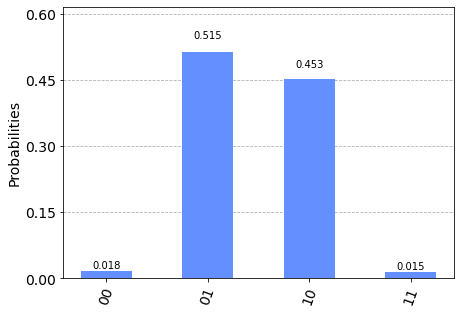

In [19]:
qc = circuit(params0, params1)
qc.cx(0,1)
qc.measure_all()
counts = execute(qc, qasm_backend).result().get_counts() # default number of shots = 1024
plot_histogram(counts)

## Variations in number of measurements (noiseless)

### i) 1 measurement

Since we are making a measurement only once, it is obvious that new state will yield either $|01\rangle$ or $|10\rangle$.

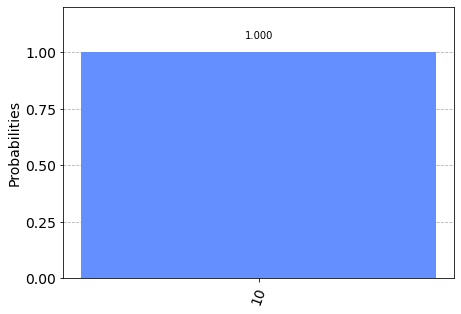

In [20]:
shots = 1
counts = execute(qc, qasm_backend, shots=shots).result().get_counts()
plot_histogram(counts)

### ii) 10 measurements

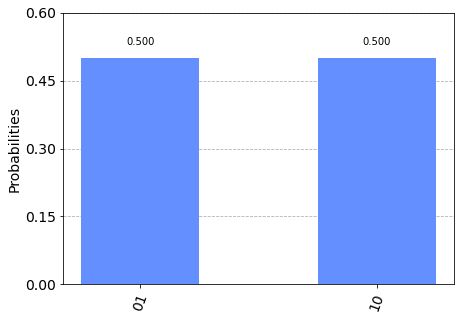

In [21]:
shots = 10
counts = execute(qc, qasm_backend, shots=shots).result().get_counts()
plot_histogram(counts)

### iii) 100 measurements

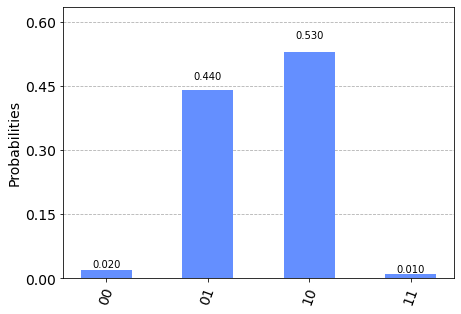

In [22]:
shots = 100
counts = execute(qc, qasm_backend, shots=shots).result().get_counts()
plot_histogram(counts)

### iv) 1000 measurements

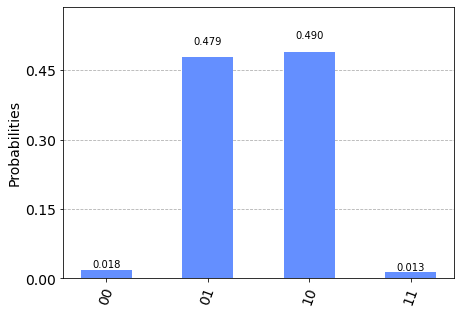

In [23]:
shots = 1000
counts = execute(qc, qasm_backend, shots=shots).result().get_counts()
plot_histogram(counts)

## Variation in number of measurements (with noise)

### i) 1 shot

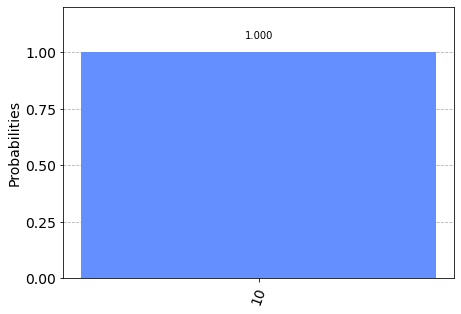

In [24]:
shots = 1
counts = execute(qc, qasm_backend, shots=shots, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

### ii) 10 shots

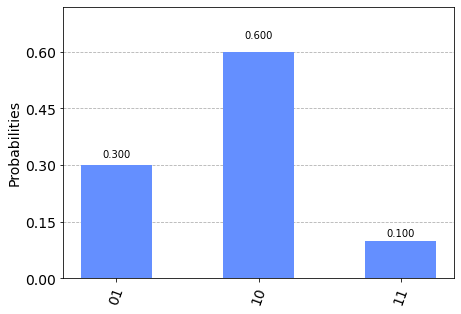

In [25]:
shots = 10
counts = execute(qc, qasm_backend, shots=shots, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

### iii) 100 shots

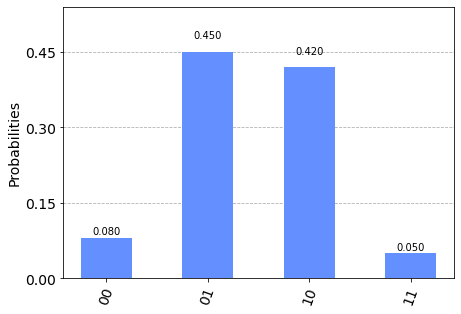

In [26]:
shots = 100
counts = execute(qc, qasm_backend, shots=shots, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

### iv) 1000 shots

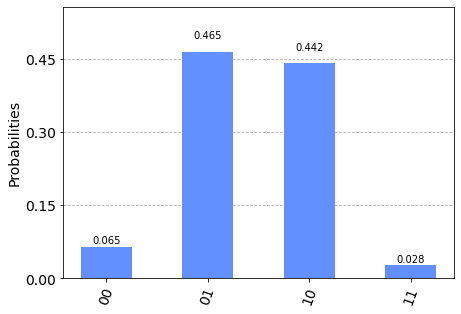

In [27]:
shots = 1000
counts = execute(qc, qasm_backend, shots=shots, coupling_map=coupling_map, basis_gates=basis_gates, noise_model=noise_model).result().get_counts()
plot_histogram(counts)

# Implementation in PennyLane

Pennylane provides builtin optimizers including batch gradient descent to optimize the parameters instead of our former approach which was by hand.

In [28]:
# Necessary imports
import pennylane as qml
from pennylane import numpy as np

## Construction of the circuit
PennyLane provides us with built-in optimizers that will take care of the mathematical rigor that we implemented above in Qiskit. For this reason, we directly construct the parameterized circuit and measure the probability of measuring the states $|00 \rangle$, $|01 \rangle$, $|10 \rangle$ and $|11 \rangle$.

In [29]:
# Defining the device (backend) to use
dev = qml.device("default.qubit", wires=2, shots=1000, analytic=False)

# Define a parameterized circuit
# params = [q0_theta0, q0_theta1, q1_theta0, q1_theta1]
@qml.qnode(dev)
def pennylane_circuit(params):
    qml.RY(params[0], wires=0)
    qml.RX(params[1], wires=0)
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=1)
    qml.CNOT(wires=[0,1])
    
    # return the probabilies of the states as a list
    return qml.probs(wires=[0,1])


After our initial qubit state $|00 \rangle$ undergoes operations under the parameterized, we arrive at a state say $| \psi \rangle$.

In [30]:
# Define a function that returns the probability of measuring a state of this composite system
# state = 0,1,2 or 3 where 0 = |00>, 1 = |01>, 2 = |10>, 3 = |11>
def probability(circuit, params, state):
    return circuit(params)[state]


## Cost function
Since we are using the entire circuit to optimize (unlike the case with Qiskit where we optimized upto the CNOT gate and treated both the qubits as 2 separate optimization problems), we will be optimizing the parameters of both the qubits at once. For this we'll implement a very straightforward cost function as a function of probabilities as implemented in our implementation in Qiskit.

A simple cost function would be

$$
J = (P_{00}^2 + (P_{01} - 0.5)^2 + (P_{10} - 0.5)^2 + P_{11}^2)
$$

Or as implemented in our code, it would be

$$
J = (P_0^2 + (P_1 - 0.5)^2 + (P_2 - 0.5)^2 + P_3^2)
$$

where $P_0 = | \langle 00 | \psi \rangle |^2$, $P_1 = | \langle 01 | \psi \rangle |^2$, $P_2 = | \langle 10 | \psi \rangle |^2$ and $P_3 = | \langle 11 | \psi \rangle |^2$.

Let us define this cost function in our code.

In [31]:
# Cost function with params = [q0_theta0, q0_theta1, q1_theta0, q1_theta1]
def pennylane_cost(params):
    return (probability(pennylane_circuit, params, 0)**2 + (probability(pennylane_circuit, params, 1) - 0.5)**2 + (probability(pennylane_circuit, params, 2) - 0.5)**2 + probability(pennylane_circuit, params, 3)**2)

## Optimizing $|q_0 \rangle$ using Gradient Descent

In [32]:
# Initial parameters (assign random values)
init_params = [random.uniform(0.001, 2*np.pi) for i in range(4)]

# Optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

In [33]:
# Number of iterations
steps = 100

# Assign initial parameters to a variable 'params' to be optimized
params = init_params.copy()

In [34]:
# Optimization over every loop
for i in range(steps):
    params = opt.step(pennylane_cost, params)
    
    if (i+1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i+1, pennylane_cost(params)))

Cost after step     5:  0.2893830
Cost after step    10:  0.1986650
Cost after step    15:  0.0850620
Cost after step    20:  0.0292220
Cost after step    25:  0.0142200
Cost after step    30:  0.0048940
Cost after step    35:  0.0046260
Cost after step    40:  0.0038700
Cost after step    45:  0.0029170
Cost after step    50:  0.0013320
Cost after step    55:  0.0014780
Cost after step    60:  0.0009620
Cost after step    65:  0.0009860
Cost after step    70:  0.0021900
Cost after step    75:  0.0009710
Cost after step    80:  0.0002760
Cost after step    85:  0.0010100
Cost after step    90:  0.0006090
Cost after step    95:  0.0000900
Cost after step   100:  0.0004110


### Optimized parameters after gradient descent

In [35]:
print("Optimized parameters for qubit0: \nRY_angle = {}   RX_angle = {}\n".format(params[0], params[1]))
print("Optimized parameters for qubit1: \nRY_angle = {}   RX_angle = {}".format(params[2], params[3]))

Optimized parameters for qubit0: 
RY_angle = 4.724002918740956   RX_angle = 5.845077714318719

Optimized parameters for qubit1: 
RY_angle = 3.3050522244431573   RX_angle = 0.18004993039858852


### Variation in number of measurements

Change the number of `dev.shots` to vary the number of measurements

In [36]:
# Number of measurements (change the number and execute the following cell block)
#dev.shots = 1
#dev.shots = 10
#dev.shots = 100
dev.shots = 1000

In [37]:
# Print the probabilities of states after optimization
print("Probability of measuring states:\n")
print("|00> =", pennylane_circuit(params)[0])
print("|01> =", pennylane_circuit(params)[1])
print("|10> =", pennylane_circuit(params)[2])
print("|11> =", pennylane_circuit(params)[3])

Probability of measuring states:

|00> = 0.004
|01> = 0.5
|10> = 0.466
|11> = 0.009


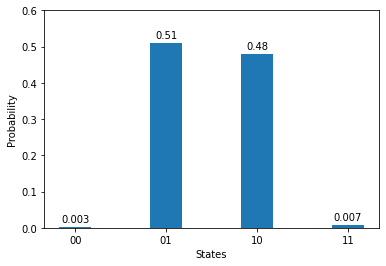

In [38]:
# Histogram plot of the probabilities
labels = ['00', '01', '10', '11']
fig, ax = plt.subplots()
width = 0.35
rects = ax.bar(labels, pennylane_circuit(params), width)
ax.set_ylabel('Probability')
ax.set_xlabel('States')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
        xy=(rect.get_x() + rect.get_width() / 2, height),
              xytext=(0, 3),  # 3 points vertical offset
              textcoords="offset points",
              ha='center', va='bottom')
autolabel(rects)

plt.ylim(0, 0.6)
plt.show()

## Bonus question: How to make sure that you produce the state $|01 \rangle + |10 \rangle$ and not $|01 \rangle + e^{i\phi}|10 \rangle$ (which includes $|01\rangle - |10\rangle$)

Let us find the state of the system before making the measurement. For this we shall use the 'statevector_simulator' as our backend in Qiskit which allows us to know the state of the system without destroying it. We shall then plot this statevector on a qsphere.

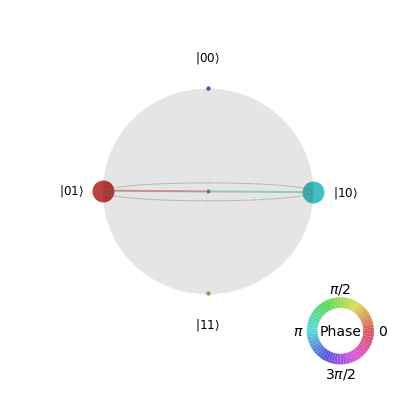

In [39]:
# Defining a circuit with the optimized parameters
circ = circuit(params0, params1)
circ.cx(0,1)
final_state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(final_state)

The optimization that we did to get the required parameters only satisfy the criteria of getting $|01\rangle$ and $|10\rangle$ with equal probabilies. We need to come up with a mechanism to filter out all such states except $\frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)$.

## Approach

The aim is to optimize the parameters in such a way that the parameterized gates acting on $q_0$ ($R_X$ and $R_Y$) behave as the Hadamard gate $H$. This way we obtain the desired state of $\frac{1}{\sqrt{2}}(|01 \rangle + |10 \rangle)$.

At the end of the circuit optimization (before CNOT gate), $q_0$ ends up in the state $\frac{1}{\sqrt{2}}(|01\rangle + e^{i\phi}|10\rangle)$. 

However we desire $q_0$ to end up in the state $|+\rangle$. This is the same as applying a Hadamard gate at the end of $q_0$ to obtain the state $|0\rangle$ i.e.

$$
H |+\rangle = |0\rangle
$$


After applying $R_Y(\theta_0)$ and $R_X(\theta_1)$ on our initial state $|0\rangle$, we obtain the state,

$$
|\psi\rangle = 
\begin{pmatrix}
\cos \frac{\theta_0}{2} \cos \frac{\theta_1}{2} - i \sin \frac{\theta_0}{2} \sin \frac{\theta_1} {2} \\
-i \sin \frac{\theta_1}{2} \cos \frac{\theta_0}{2} + \cos \frac{\theta_1}{2} \sin \frac{\theta_0}{2} \\
\end{pmatrix}
$$

We now proceed to apply the Hadamard $H$ gate on $|\psi\rangle$ i.e. $H |\psi \rangle = |\psi_0 \rangle$ to obtain,

$$
|\psi_0 \rangle = 
\frac{1}{\sqrt{2}}
\begin{pmatrix}
\cos{\frac{\theta_0}{2}} \left(\cos{\frac{\theta_0}{2}} + \sin{\frac{\theta_0}{2}}\right) - i \sin{\frac{\theta_1}{2}} \left(\sin{\frac{\theta_0}{2}} + \cos{\frac{\theta_0}{2}}\right) \\
\cos{\frac{\theta_1}{2}} \left(\cos{\frac{\theta_0}{2}} - \sin{\frac{\theta_0}{2}}\right) + i \sin{\frac{\theta_1}{2}} \left(\cos{\frac{\theta_0}{2}} - \sin{\frac{\theta_0}{2}}\right) \\
\end{pmatrix}
$$

where
$$
H = 
\frac{1}{\sqrt{2}}
\begin{pmatrix}
1 & 1 \\
1 & -1 \\
\end{pmatrix}
$$

On simplifying the terms and appropriately multiplying phase terms,

$$
|\psi_0 \rangle = 
\frac{1}{\sqrt{2}}
\begin{pmatrix}
\cos{\frac{\theta_0}{2}} + \sin{\frac{\theta_0}{2}} \\
e^{i \theta_1} \left(\cos{\frac{\theta_0}{2}} - \sin{\frac{\theta_0}{2}}\right) \\
\end{pmatrix}
$$



We now have to define a cost function to effectively only keep the state $|0 \rangle$ i.e., to minimize the probability of measuring the state $|1\rangle$ and to reduce the phase factor $e^{i\theta_1}$.

This optimization is not required for $q_1$ since during the former optimization step, $q_1 = |1\rangle$. However, a global phase can always exist but it doesn't affect our results.

The probability of measuring $|1\rangle$ is
$$
P_1 = |\langle 1 | \psi_0 \rangle |^2 = \frac{1}{2} \left(\cos{\frac{\theta_0}{2}} - \sin{\frac{\theta_0}{2}}\right)^2
$$

## Cost function

A suitable cost function would be 

$$
J = P_1^2 + \sin^2{\theta_1}
$$

Calculating the partial derivatives with respect to $\theta_0$ and $\theta_1$

$$
\frac{\partial J}{\partial \theta_0} = 2P_1 \frac{\partial P_1}{\partial \theta_0}
$$

$$
\frac{\partial J}{\partial \theta_1} = 2 \sin{\theta_1} \cos{\theta_1}
$$

Evaluating the partial derivatives of $P_1$ with respect to $\theta_0$ and $\theta_1$,

$$
\frac{\partial P_1}{\partial \theta_0} = - \left( \cos^2{\frac{\theta_0}{2}} - \sin^2{\frac{\theta_0}{2}} \right)
$$

$$
\frac{\partial P_1}{\partial \theta_1} = 0
$$

In [40]:
# function that returns probability of measuring |1> where params = [theta0, theta1]
def bonus_prob1(params):
    return (np.cos(params[0]/2) - np.sin(params[0]/2))**2

In [41]:
# Cost function
def bonus_cost(params):
    return prob1(params)**2 + np.sin(params[1])**2

In [42]:
# compute the gradient with index indicating the angle (0 for theta0 ; 1 for theta1)
def bonus_gradient(params, index):
    if index == 0:
        return 2 * prob1(params) * (np.sin(params[0]/2)**2 - np.cos(params[0]/2)**2)
    elif index == 1:
        return 2 * np.sin(params[1]) * np.cos(params[1])
    else:
        print("Invalid index!")
        exit()

In [43]:
# optimizer using gradient descent
def bonus_optimizer(params, learning_rate):
    temp0 = params[0] - (learning_rate * bonus_gradient(params, 0))
    temp1 = params[1] - (learning_rate * bonus_gradient(params, 1))
    params[0] = temp0
    params[1] = temp1

In [44]:
# Number of iterations
iterations = 100

# Learning rate
learning_rate = 0.4

In [45]:
for i in range(iterations):
    bonus_optimizer(params0, learning_rate)
    
    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i+1, bonus_cost(params0)))

Cost after step     5:  0.2501235
Cost after step    10:  0.2506633
Cost after step    15:  0.2535924
Cost after step    20:  0.2700714
Cost after step    25:  0.3828398
Cost after step    30:  0.8293813
Cost after step    35:  0.2651836
Cost after step    40:  0.2511130
Cost after step    45:  0.2500862
Cost after step    50:  0.2500067
Cost after step    55:  0.2500005
Cost after step    60:  0.2500000
Cost after step    65:  0.2500000
Cost after step    70:  0.2500000
Cost after step    75:  0.2500000
Cost after step    80:  0.2500000
Cost after step    85:  0.2500000
Cost after step    90:  0.2500000
Cost after step    95:  0.2500000
Cost after step   100:  0.2500000


In [46]:
print("Optimized angles for qubit 0: \nRY_angle = {}   RX_angle = {}".format(params0[0], params0[1]))

Optimized angles for qubit 0: 
RY_angle = 7.853981633974483   RX_angle = 3.141592653589793


It is nice to note that the angles turn out to be as expected from our reference circuit (with RX, RY and CNOTs) i.e., $2n\pi + \pi/2$ and $(2n+1) \pi$ for gates $R_Y$ and $R_X$ respectively where $n$ is an integer.

Let us plot the state on a Qsphere and verify our result.

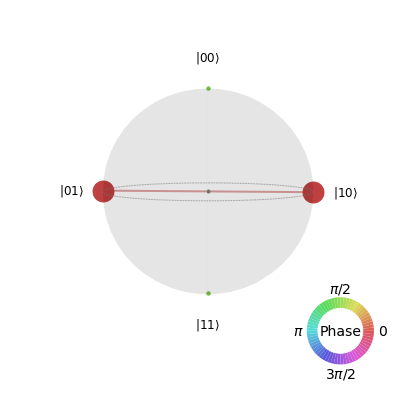

In [47]:
circ = circuit(params0, params1)
circ.cx(0,1)
state = execute(circ, statevector_backend).result().get_statevector()
plot_state_qsphere(state)

As expected, we end up with the state (upto a global phase)

$$
\frac{1}{\sqrt{2}}(|01\rangle + |10\rangle)
$$

## Note:
Even though we apply a Hadamard gate during the analysis, applying another Hadamard gate reverts $q_o$ back to $\frac{1}{\sqrt{2}} (|0\rangle + |1\rangle)$ since

$$
H H = I
$$

where $I$ is the identity matrix.

Hence, we never need to actually apply a Hadamard gate on our circuit.

# Conclusion
Thank you for having provided this wonderful problem to work on. I learnt quite a lot in the past few days. I hope you enjoyed looking at my solution just as much as I enjoyed solving it.